In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import plot_model
import scipy.stats as stats
import os 
import h5py
import sys
import re
import xgboost as xgb 
import sklearn.multioutput

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'boxcox', 'eta':'meanmax', 'phi':'linear_sincos', 'DL1r':'meanmax', 'm':'divmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 7.958078640513122e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(80000, 44) (80000, 12)
(20000, 44) (20000, 12)


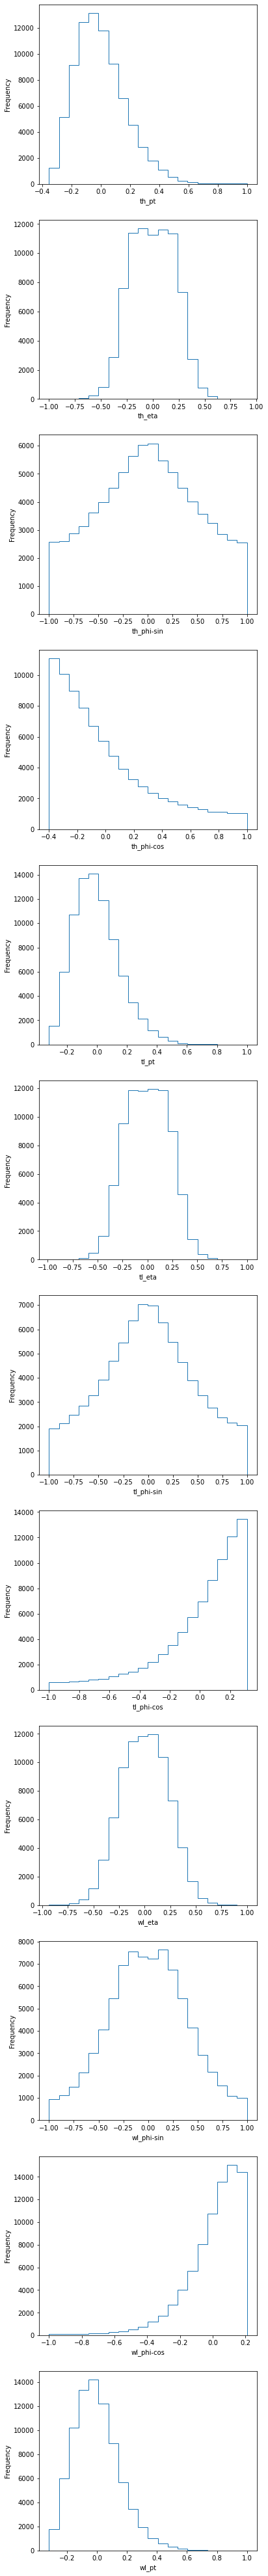

In [4]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        plt.hist(trainY[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

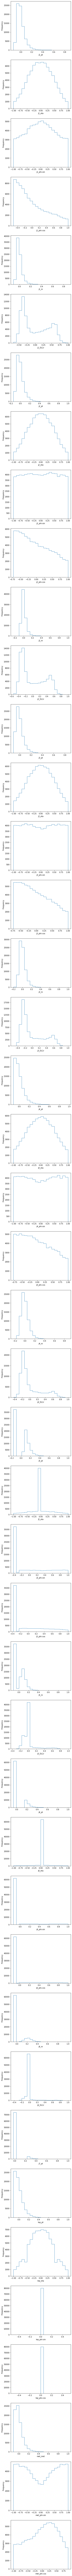

In [5]:
# Histograms of X variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainX.shape[1]))
    for i in range(0, trainX.shape[1]):
        plt.subplot(trainX.shape[1], 1, i+1)
        plt.hist(trainX[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(X_names)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(Y_names),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      X_shape=[len(X_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               23040     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [8]:
# Fit model

Epochs= 2048

history = model.fit(trainX, trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Train on 64000 samples, validate on 16000 samples
Epoch 1/2048
64000/64000 [==============================] - 2s 28us/sample - loss: 0.0992 - mse: 0.0911 - val_loss: 0.0975 - val_mse: 0.0894
Epoch 2/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0989 - mse: 0.0907 - val_loss: 0.0972 - val_mse: 0.0891
Epoch 3/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0986 - mse: 0.0904 - val_loss: 0.0969 - val_mse: 0.0888
Epoch 4/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0983 - mse: 0.0901 - val_loss: 0.0966 - val_mse: 0.0885
Epoch 5/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0980 - mse: 0.0899 - val_loss: 0.0963 - val_mse: 0.0882
Epoch 6/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0977 - mse: 0.0896 - val_loss: 0.0960 - val_mse: 0.0879
Epoch 7/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0973 - mse: 0.0893 -

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0700 - mse: 0.0624 - val_loss: 0.0691 - val_mse: 0.0616
Epoch 59/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0698 - mse: 0.0623 - val_loss: 0.0689 - val_mse: 0.0614
Epoch 60/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0696 - mse: 0.0621 - val_loss: 0.0688 - val_mse: 0.0613
Epoch 61/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0694 - mse: 0.0619 - val_loss: 0.0686 - val_mse: 0.0611
Epoch 62/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0693 - mse: 0.0618 - val_loss: 0.0684 - val_mse: 0.0610
Epoch 63/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0691 - mse: 0.0616 - val_loss: 0.0683 - val_mse: 0.0608
Epoch 64/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0689 - mse: 0.0615 - val_loss: 0.0681 - val_mse: 0.0607
Epoch 65/2048
64000/640

Epoch 116/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0641 - mse: 0.0570 - val_loss: 0.0635 - val_mse: 0.0564
Epoch 117/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0640 - mse: 0.0569 - val_loss: 0.0635 - val_mse: 0.0564
Epoch 118/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0640 - mse: 0.0569 - val_loss: 0.0634 - val_mse: 0.0563
Epoch 119/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0639 - mse: 0.0568 - val_loss: 0.0634 - val_mse: 0.0563
Epoch 120/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0638 - mse: 0.0567 - val_loss: 0.0633 - val_mse: 0.0562
Epoch 121/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0638 - mse: 0.0567 - val_loss: 0.0633 - val_mse: 0.0562
Epoch 122/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0637 - mse: 0.0566 - val_loss: 0.0632 - val_mse: 0.0561
Epoc

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0610 - mse: 0.0542 - val_loss: 0.0607 - val_mse: 0.0539
Epoch 174/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0610 - mse: 0.0542 - val_loss: 0.0606 - val_mse: 0.0538
Epoch 175/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0609 - mse: 0.0541 - val_loss: 0.0606 - val_mse: 0.0538
Epoch 176/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0609 - mse: 0.0541 - val_loss: 0.0605 - val_mse: 0.0538
Epoch 177/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0608 - mse: 0.0541 - val_loss: 0.0605 - val_mse: 0.0537
Epoch 178/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0608 - mse: 0.0540 - val_loss: 0.0605 - val_mse: 0.0537
Epoch 179/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0607 - mse: 0.0540 - val_loss: 0.0604 - val_mse: 0.0537
Epoch 180/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0589 - mse: 0.0523 - val_loss: 0.0588 - val_mse: 0.0522
Epoch 231/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0588 - mse: 0.0523 - val_loss: 0.0587 - val_mse: 0.0522
Epoch 232/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0588 - mse: 0.0523 - val_loss: 0.0587 - val_mse: 0.0522
Epoch 233/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0588 - mse: 0.0523 - val_loss: 0.0587 - val_mse: 0.0522
Epoch 234/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0587 - mse: 0.0522 - val_loss: 0.0587 - val_mse: 0.0521
Epoch 235/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0587 - mse: 0.0522 - val_loss: 0.0586 - val_mse: 0.0521
Epoch 236/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0587 - mse: 0.0522 - val_loss: 0.0586 - val_mse: 0.0521
Epoch 237/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0573 - mse: 0.0510 - val_loss: 0.0574 - val_mse: 0.0511
Epoch 288/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0573 - mse: 0.0510 - val_loss: 0.0574 - val_mse: 0.0511
Epoch 289/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0573 - mse: 0.0510 - val_loss: 0.0574 - val_mse: 0.0511
Epoch 290/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0573 - mse: 0.0510 - val_loss: 0.0574 - val_mse: 0.0511
Epoch 291/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0572 - mse: 0.0509 - val_loss: 0.0574 - val_mse: 0.0511
Epoch 292/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0572 - mse: 0.0509 - val_loss: 0.0573 - val_mse: 0.0510
Epoch 293/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0572 - mse: 0.0509 - val_loss: 0.0573 - val_mse: 0.0510
Epoch 294/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0561 - mse: 0.0500 - val_loss: 0.0564 - val_mse: 0.0503
Epoch 345/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0561 - mse: 0.0500 - val_loss: 0.0564 - val_mse: 0.0503
Epoch 346/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0560 - mse: 0.0499 - val_loss: 0.0564 - val_mse: 0.0503
Epoch 347/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0560 - mse: 0.0499 - val_loss: 0.0563 - val_mse: 0.0502
Epoch 348/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0560 - mse: 0.0499 - val_loss: 0.0563 - val_mse: 0.0502
Epoch 349/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0560 - mse: 0.0499 - val_loss: 0.0563 - val_mse: 0.0502
Epoch 350/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0560 - mse: 0.0499 - val_loss: 0.0563 - val_mse: 0.0502
Epoch 351/2048
64

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0550 - mse: 0.0491 - val_loss: 0.0555 - val_mse: 0.0496
Epoch 402/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0550 - mse: 0.0490 - val_loss: 0.0555 - val_mse: 0.0496
Epoch 403/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0550 - mse: 0.0490 - val_loss: 0.0555 - val_mse: 0.0495
Epoch 404/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0549 - mse: 0.0490 - val_loss: 0.0555 - val_mse: 0.0495
Epoch 405/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0549 - mse: 0.0490 - val_loss: 0.0554 - val_mse: 0.0495
Epoch 406/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0549 - mse: 0.0490 - val_loss: 0.0554 - val_mse: 0.0495
Epoch 407/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0549 - mse: 0.0490 - val_loss: 0.0554 - val_mse: 0.0495
Epoch 408/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0540 - mse: 0.0482 - val_loss: 0.0548 - val_mse: 0.0490
Epoch 459/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0540 - mse: 0.0482 - val_loss: 0.0547 - val_mse: 0.0489
Epoch 460/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0540 - mse: 0.0482 - val_loss: 0.0547 - val_mse: 0.0489
Epoch 461/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0540 - mse: 0.0482 - val_loss: 0.0547 - val_mse: 0.0489
Epoch 462/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0540 - mse: 0.0482 - val_loss: 0.0547 - val_mse: 0.0489
Epoch 463/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0539 - mse: 0.0482 - val_loss: 0.0547 - val_mse: 0.0489
Epoch 464/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0539 - mse: 0.0482 - val_loss: 0.0547 - val_mse: 0.0489
Epoch 465/2048
6

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0531 - mse: 0.0475 - val_loss: 0.0541 - val_mse: 0.0484
Epoch 516/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0531 - mse: 0.0475 - val_loss: 0.0541 - val_mse: 0.0484
Epoch 517/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0531 - mse: 0.0475 - val_loss: 0.0541 - val_mse: 0.0484
Epoch 518/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0531 - mse: 0.0474 - val_loss: 0.0541 - val_mse: 0.0484
Epoch 519/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0531 - mse: 0.0474 - val_loss: 0.0540 - val_mse: 0.0484
Epoch 520/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0531 - mse: 0.0474 - val_loss: 0.0540 - val_mse: 0.0484
Epoch 521/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0531 - mse: 0.0474 - val_loss: 0.0540 - val_mse: 0.0484
Epoch 522/2048
640

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0523 - mse: 0.0468 - val_loss: 0.0535 - val_mse: 0.0480
Epoch 573/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0523 - mse: 0.0468 - val_loss: 0.0535 - val_mse: 0.0480
Epoch 574/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0523 - mse: 0.0468 - val_loss: 0.0535 - val_mse: 0.0479
Epoch 575/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0523 - mse: 0.0468 - val_loss: 0.0535 - val_mse: 0.0479
Epoch 576/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0523 - mse: 0.0467 - val_loss: 0.0535 - val_mse: 0.0479
Epoch 577/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0523 - mse: 0.0467 - val_loss: 0.0535 - val_mse: 0.0479
Epoch 578/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0523 - mse: 0.0467 - val_loss: 0.0535 - val_mse: 0.0479
Epoch 579/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0516 - mse: 0.0461 - val_loss: 0.0530 - val_mse: 0.0476
Epoch 630/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0516 - mse: 0.0461 - val_loss: 0.0530 - val_mse: 0.0476
Epoch 631/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0516 - mse: 0.0461 - val_loss: 0.0530 - val_mse: 0.0475
Epoch 632/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0516 - mse: 0.0461 - val_loss: 0.0530 - val_mse: 0.0475
Epoch 633/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0515 - mse: 0.0461 - val_loss: 0.0530 - val_mse: 0.0475
Epoch 634/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0515 - mse: 0.0461 - val_loss: 0.0530 - val_mse: 0.0475
Epoch 635/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0515 - mse: 0.0461 - val_loss: 0.0530 - val_mse: 0.0475
Epoch 636/2048
6

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0456 - val_loss: 0.0526 - val_mse: 0.0472
Epoch 687/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0456 - val_loss: 0.0526 - val_mse: 0.0472
Epoch 688/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0455 - val_loss: 0.0526 - val_mse: 0.0472
Epoch 689/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0455 - val_loss: 0.0525 - val_mse: 0.0472
Epoch 690/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0455 - val_loss: 0.0525 - val_mse: 0.0472
Epoch 691/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0455 - val_loss: 0.0525 - val_mse: 0.0472
Epoch 692/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0455 - val_loss: 0.0525 - val_mse: 0.0472
Epoch 693/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0503 - mse: 0.0450 - val_loss: 0.0522 - val_mse: 0.0469
Epoch 744/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0503 - mse: 0.0450 - val_loss: 0.0522 - val_mse: 0.0469
Epoch 745/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0503 - mse: 0.0450 - val_loss: 0.0522 - val_mse: 0.0469
Epoch 746/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0503 - mse: 0.0450 - val_loss: 0.0522 - val_mse: 0.0469
Epoch 747/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0503 - mse: 0.0450 - val_loss: 0.0522 - val_mse: 0.0469
Epoch 748/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0503 - mse: 0.0450 - val_loss: 0.0522 - val_mse: 0.0469
Epoch 749/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0502 - mse: 0.0450 - val_loss: 0.0522 - val_mse: 0.0469
Epoch 750/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0497 - mse: 0.0446 - val_loss: 0.0519 - val_mse: 0.0467
Epoch 801/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0497 - mse: 0.0445 - val_loss: 0.0519 - val_mse: 0.0467
Epoch 802/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0497 - mse: 0.0445 - val_loss: 0.0519 - val_mse: 0.0467
Epoch 803/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0497 - mse: 0.0445 - val_loss: 0.0519 - val_mse: 0.0467
Epoch 804/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0497 - mse: 0.0445 - val_loss: 0.0519 - val_mse: 0.0467
Epoch 805/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0497 - mse: 0.0445 - val_loss: 0.0519 - val_mse: 0.0467
Epoch 806/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0497 - mse: 0.0445 - val_loss: 0.0519 - val_mse: 0.0467
Epoch 807/2048
6

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0492 - mse: 0.0441 - val_loss: 0.0516 - val_mse: 0.0465
Epoch 858/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0492 - mse: 0.0441 - val_loss: 0.0516 - val_mse: 0.0465
Epoch 859/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0492 - mse: 0.0441 - val_loss: 0.0516 - val_mse: 0.0465
Epoch 860/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0492 - mse: 0.0441 - val_loss: 0.0516 - val_mse: 0.0465
Epoch 861/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0492 - mse: 0.0441 - val_loss: 0.0516 - val_mse: 0.0465
Epoch 862/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0492 - mse: 0.0441 - val_loss: 0.0516 - val_mse: 0.0465
Epoch 863/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0492 - mse: 0.0441 - val_loss: 0.0516 - val_mse: 0.0465
Epoch 864/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0487 - mse: 0.0437 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 915/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0487 - mse: 0.0437 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 916/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0487 - mse: 0.0437 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 917/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0487 - mse: 0.0437 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 918/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0487 - mse: 0.0437 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 919/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0487 - mse: 0.0437 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 920/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0487 - mse: 0.0437 - val_loss: 0.0514 - val_mse: 0.0463
Epoch 921/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0483 - mse: 0.0433 - val_loss: 0.0512 - val_mse: 0.0462
Epoch 972/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0483 - mse: 0.0433 - val_loss: 0.0512 - val_mse: 0.0462
Epoch 973/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0483 - mse: 0.0433 - val_loss: 0.0512 - val_mse: 0.0462
Epoch 974/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0483 - mse: 0.0433 - val_loss: 0.0512 - val_mse: 0.0462
Epoch 975/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0483 - mse: 0.0433 - val_loss: 0.0512 - val_mse: 0.0462
Epoch 976/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0483 - mse: 0.0433 - val_loss: 0.0512 - val_mse: 0.0462
Epoch 977/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0483 - mse: 0.0433 - val_loss: 0.0512 - val_mse: 0.0462
Epoch 978/2048

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0479 - mse: 0.0429 - val_loss: 0.0510 - val_mse: 0.0461
Epoch 1029/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0479 - mse: 0.0429 - val_loss: 0.0510 - val_mse: 0.0461
Epoch 1030/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0479 - mse: 0.0429 - val_loss: 0.0510 - val_mse: 0.0461
Epoch 1031/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0479 - mse: 0.0429 - val_loss: 0.0510 - val_mse: 0.0461
Epoch 1032/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0478 - mse: 0.0429 - val_loss: 0.0510 - val_mse: 0.0461
Epoch 1033/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0478 - mse: 0.0429 - val_loss: 0.0510 - val_mse: 0.0461
Epoch 1034/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0478 - mse: 0.0429 - val_loss: 0.0510 - val_mse: 0.0461
Epoch 10

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0475 - mse: 0.0426 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 1086/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0475 - mse: 0.0426 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 1087/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0475 - mse: 0.0426 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 1088/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0474 - mse: 0.0426 - val_loss: 0.0509 - val_mse: 0.0460
Epoch 1089/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0474 - mse: 0.0426 - val_loss: 0.0508 - val_mse: 0.0460
Epoch 1090/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0474 - mse: 0.0426 - val_loss: 0.0508 - val_mse: 0.0460
Epoch 1091/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0474 - mse: 0.0426 - val_loss: 0.0508 - val_mse: 0.0460
Epoch 1092/

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0471 - mse: 0.0423 - val_loss: 0.0507 - val_mse: 0.0459
Epoch 1143/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0471 - mse: 0.0423 - val_loss: 0.0507 - val_mse: 0.0459
Epoch 1144/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0471 - mse: 0.0423 - val_loss: 0.0507 - val_mse: 0.0459
Epoch 1145/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0471 - mse: 0.0423 - val_loss: 0.0507 - val_mse: 0.0459
Epoch 1146/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0471 - mse: 0.0422 - val_loss: 0.0507 - val_mse: 0.0459
Epoch 1147/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0471 - mse: 0.0422 - val_loss: 0.0507 - val_mse: 0.0459
Epoch 1148/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0470 - mse: 0.0422 - val_loss: 0.0507 - val_mse: 0.0459
Epoch 11

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0467 - mse: 0.0420 - val_loss: 0.0506 - val_mse: 0.0458
Epoch 1200/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0467 - mse: 0.0419 - val_loss: 0.0506 - val_mse: 0.0458
Epoch 1201/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0467 - mse: 0.0419 - val_loss: 0.0506 - val_mse: 0.0458
Epoch 1202/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0467 - mse: 0.0419 - val_loss: 0.0506 - val_mse: 0.0458
Epoch 1203/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0419 - val_loss: 0.0506 - val_mse: 0.0458
Epoch 1204/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0467 - mse: 0.0419 - val_loss: 0.0506 - val_mse: 0.0458
Epoch 1205/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0467 - mse: 0.0419 - val_loss: 0.0506 - val_mse: 0.0458
Epoch 1206

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0464 - mse: 0.0416 - val_loss: 0.0505 - val_mse: 0.0458
Epoch 1257/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0464 - mse: 0.0416 - val_loss: 0.0505 - val_mse: 0.0458
Epoch 1258/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0463 - mse: 0.0416 - val_loss: 0.0505 - val_mse: 0.0458
Epoch 1259/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0463 - mse: 0.0416 - val_loss: 0.0505 - val_mse: 0.0458
Epoch 1260/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0463 - mse: 0.0416 - val_loss: 0.0505 - val_mse: 0.0458
Epoch 1261/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0463 - mse: 0.0416 - val_loss: 0.0505 - val_mse: 0.0458
Epoch 1262/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0463 - mse: 0.0416 - val_loss: 0.0505 - val_mse: 0.0458
Epoch 12

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0413 - val_loss: 0.0504 - val_mse: 0.0458
Epoch 1314/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0413 - val_loss: 0.0504 - val_mse: 0.0458
Epoch 1315/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0413 - val_loss: 0.0504 - val_mse: 0.0458
Epoch 1316/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0413 - val_loss: 0.0504 - val_mse: 0.0458
Epoch 1317/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0413 - val_loss: 0.0504 - val_mse: 0.0458
Epoch 1318/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0413 - val_loss: 0.0504 - val_mse: 0.0458
Epoch 1319/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0460 - mse: 0.0413 - val_loss: 0.0504 - val_mse: 0.0458
Epoch 13

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0457 - mse: 0.0411 - val_loss: 0.0504 - val_mse: 0.0457
Epoch 1371/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0457 - mse: 0.0411 - val_loss: 0.0504 - val_mse: 0.0457
Epoch 1372/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0457 - mse: 0.0411 - val_loss: 0.0504 - val_mse: 0.0457
Epoch 1373/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0457 - mse: 0.0410 - val_loss: 0.0504 - val_mse: 0.0457
Epoch 1374/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0457 - mse: 0.0410 - val_loss: 0.0504 - val_mse: 0.0457
Epoch 1375/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0457 - mse: 0.0410 - val_loss: 0.0504 - val_mse: 0.0457
Epoch 1376/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0456 - mse: 0.0410 - val_loss: 0.0504 - val_mse: 0.0457
Epoch 137

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0454 - mse: 0.0408 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1428/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0454 - mse: 0.0408 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1429/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0454 - mse: 0.0408 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1430/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1431/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1432/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1433/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0453 - mse: 0.0408 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 143

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0450 - mse: 0.0405 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1485/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0450 - mse: 0.0405 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1486/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0450 - mse: 0.0405 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1487/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0450 - mse: 0.0405 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1488/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0450 - mse: 0.0405 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1489/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0450 - mse: 0.0405 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1490/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0450 - mse: 0.0405 - val_loss: 0.0503 - val_mse: 0.0457
Epoch 1491

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0447 - mse: 0.0402 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1542/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0447 - mse: 0.0402 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1543/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0447 - mse: 0.0402 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1544/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0447 - mse: 0.0402 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1545/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0447 - mse: 0.0402 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1546/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0447 - mse: 0.0402 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1547/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0447 - mse: 0.0402 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 15

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1599/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1600/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1601/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1602/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1603/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 1604/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0444 - mse: 0.0400 - val_loss: 0.0502 - val_mse: 0.0457
Epoch 16

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0442 - mse: 0.0397 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1656/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0441 - mse: 0.0397 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1657/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0441 - mse: 0.0397 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1658/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0441 - mse: 0.0397 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1659/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0441 - mse: 0.0397 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1660/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0441 - mse: 0.0397 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1661/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0441 - mse: 0.0397 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 166

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0439 - mse: 0.0395 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1713/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0439 - mse: 0.0395 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1714/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0439 - mse: 0.0395 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1715/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0438 - mse: 0.0395 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1716/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0438 - mse: 0.0395 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1717/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0438 - mse: 0.0394 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 1718/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0438 - mse: 0.0394 - val_loss: 0.0502 - val_mse: 0.0458
Epoch 17

Text(0.5, 1.0, 'MSE loss')

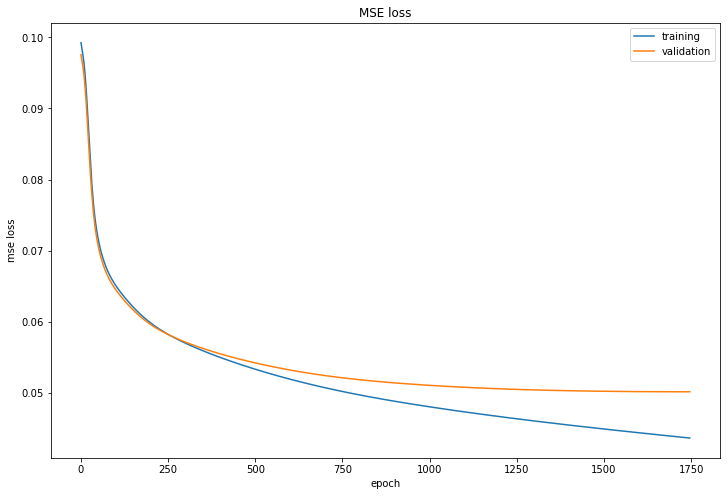

In [9]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [10]:
predictions = model.predict(testX)

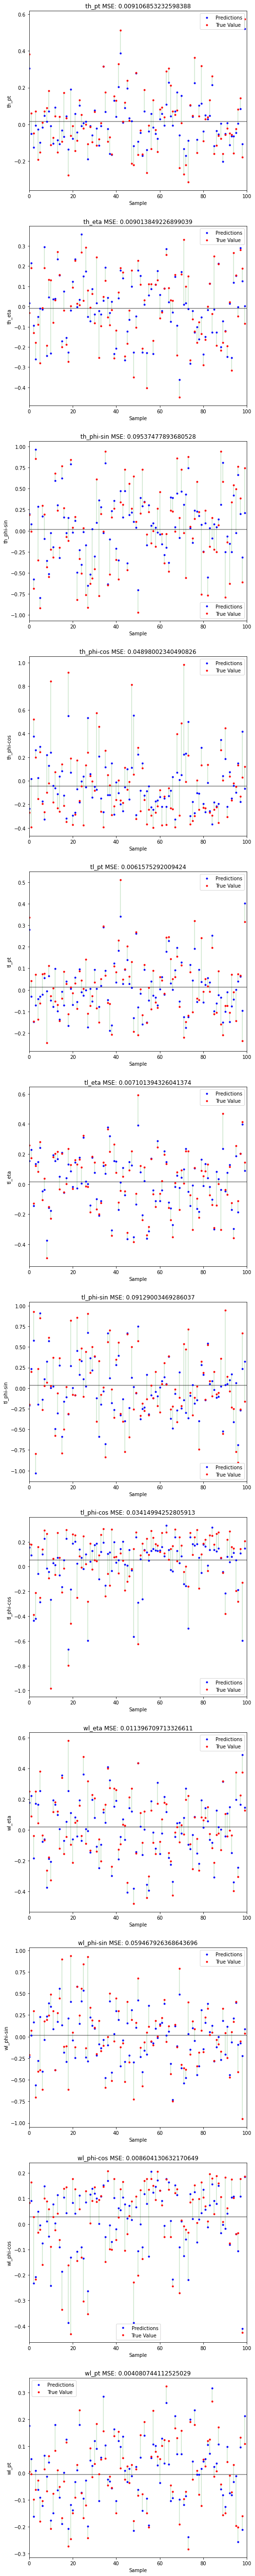

In [11]:

# Training 
crop = 100 

train_small = model.predict(trainX[0:100,:])
Y_small = trainY[0:100,:]


def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*len(Y_names)))
    for i in range(0,len(Y_names)):
        plt.subplot(len(Y_names),1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Sample')
        plt.ylabel(Y_names[i])
        plt.xlim(0, crop)
        plt.title(Y_names[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, Y_small)

In [12]:
# Predictions

predictions_small = predictions[0:100,:]
testY_small = testY[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- testY)**2)
print("total MSE: " + str(MSE))

for i in range(Y_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -testY[:,i])**2)
    print("{0} MSE : ".format(Y_names[i]), '%.10f'%MSE)

total MSE: 0.04580600400400985
th_pt MSE :  0.0105930232
th_eta MSE :  0.0129439134
th_phi-sin MSE :  0.1725320866
th_phi-cos MSE :  0.0739878241
tl_pt MSE :  0.0071856822
tl_eta MSE :  0.0104975898
tl_phi-sin MSE :  0.1274087413
tl_phi-cos MSE :  0.0439722063
wl_eta MSE :  0.0095732506


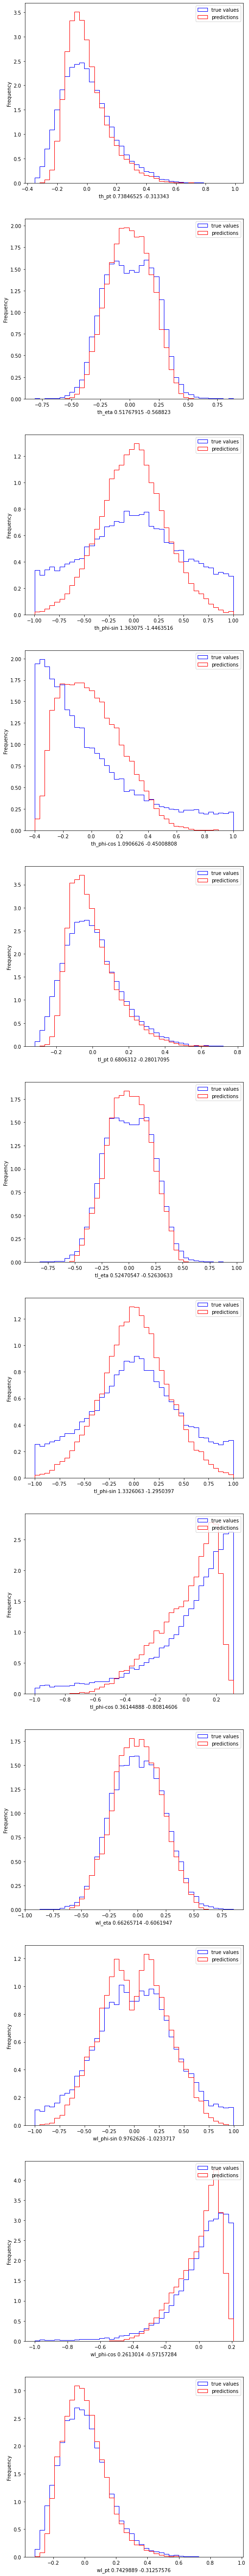

In [13]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(testY[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_names[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

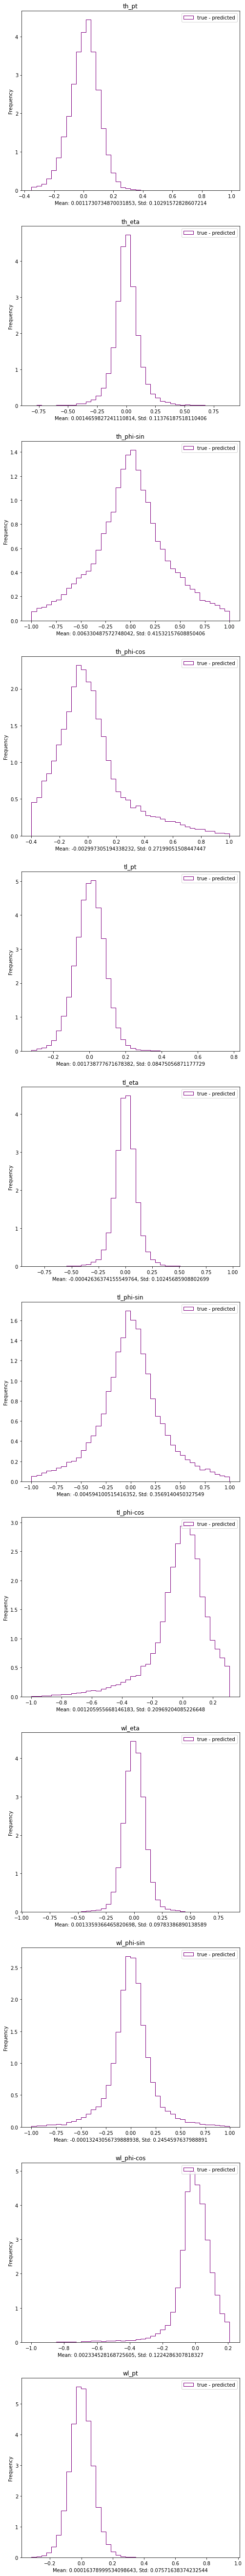

In [14]:
# True - Predicted 

plt.figure(figsize=(8,8*len(Y_names)))
for i in range(len(Y_names)):
    plt.subplot(len(Y_names), 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_names[i])
    plt.legend()
    plt.ylabel('Frequency')

In [15]:
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)
out_scaled = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

total_predictions = model.predict(X_total)
predict_scaled = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]

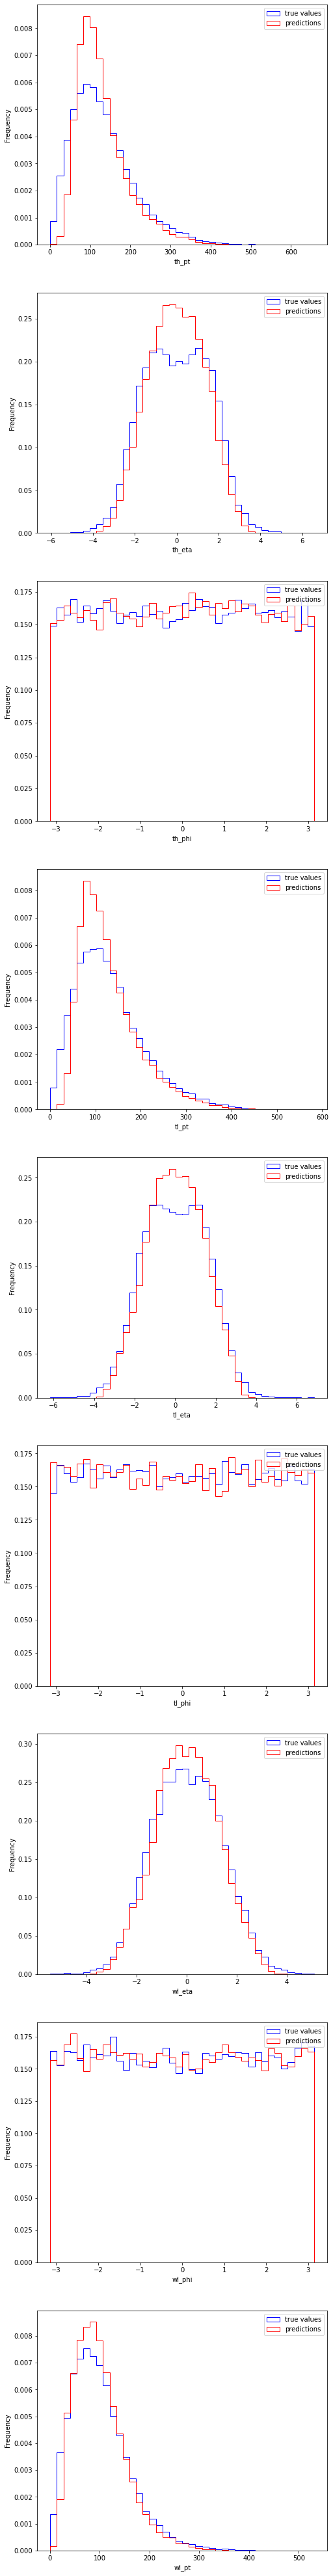

In [16]:
# Histograms to the original scale 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    hist, edges = np.histogram(out_scaled[:, i], 40)
    plt.hist(out_scaled[:, i], edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

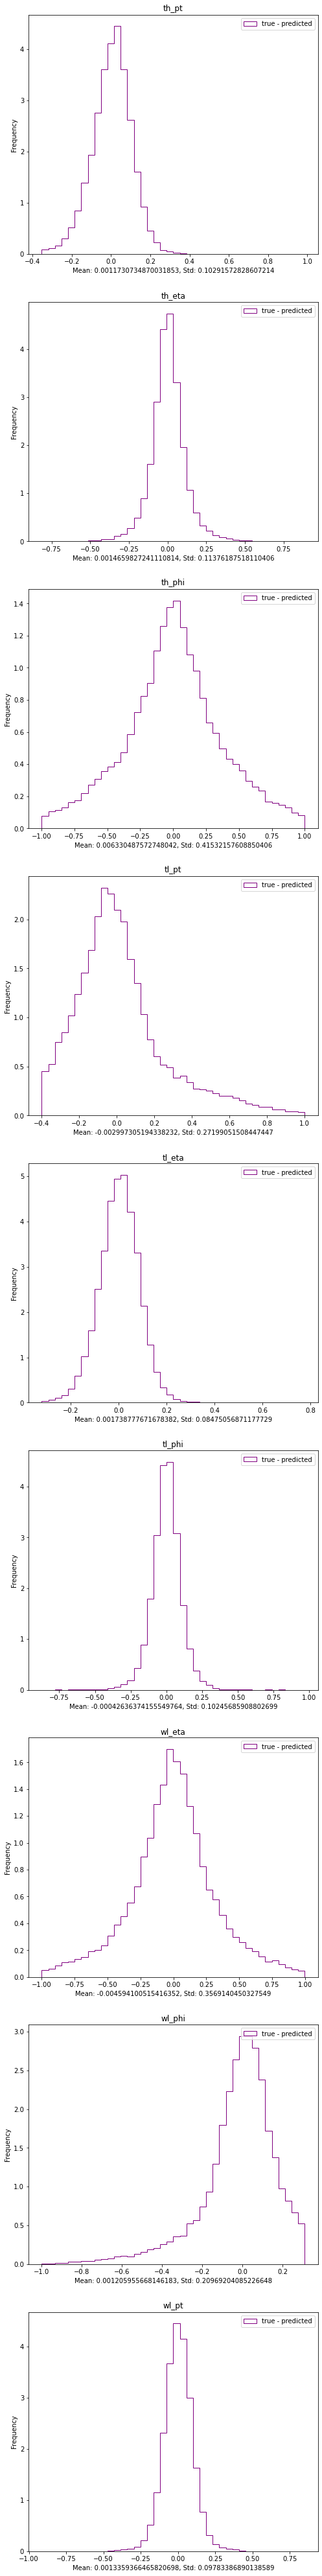

In [17]:
# True - Predicted 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

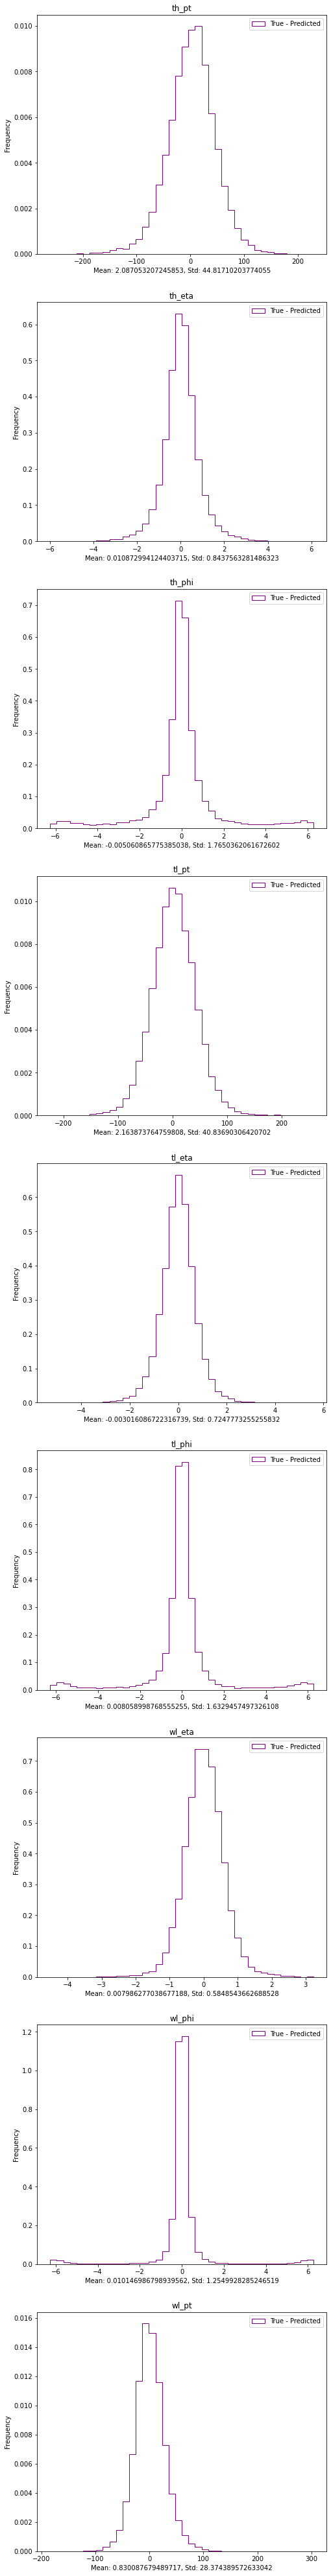

In [18]:
# Difference value histograms 
plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    diff = -predict_scaled[:, i]+out_scaled[:, i]
    plt.hist(diff, 40, histtype='step', color='purple', label='True - Predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [19]:
for i in range(Y_length):
    if Y_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(Y_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  2012.9284261511
Original Scale th_eta MSE :  0.7120429633
Original Scale th_phi MSE :  0.9186637744
Original Scale tl_pt MSE :  1672.3350015453
Original Scale tl_eta MSE :  0.5253112684
Original Scale tl_phi MSE :  0.5922553982
Original Scale wl_eta MSE :  0.3421184104
Original Scale wl_phi MSE :  0.2225616386
Original Scale wl_pt MSE :  805.7950291752


In [ ]:
plt.figure(figsize=(8,8*Y_length))
for i in range(Y_length):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + Y_keys[i])
    plt.legend()
    plt.ylabel('Difference')